In [ ]:
!pip install nlpaug
!pip install ktrain

import nlpaug.augmenter.word as naw
import numpy as np
import pandas as pd
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dropout, LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from textblob import Word
import re
from google.colab import drive

drive.mount('/content/drive')
path = 'drive/My Drive/Colab Notebooks/public-data/text_data'

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

df = pd.read_csv(path+'/public_data.csv')
df['text'] = df['text'].fillna("")
df['label'] = df['label'].astype(int)

# Preprocess our text data and clean as needed
df['lower_case'] = df['text'].apply(lambda x: x.lower().strip().replace('\n', ' ').replace('\r', ' '))
df['alphabatic'] = df['lower_case'].apply(lambda x: re.sub(r'[^a-zA-Z\']', ' ', x)).apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))
df['without-link'] = df['alphabatic'].apply(lambda x: re.sub(r'http\S+', '', x))

tokenizer = RegexpTokenizer(r'\w+')
df['Special_word'] = df.apply(lambda row: tokenizer.tokenize(row['lower_case']), axis=1)

stop = [word for word in stopwords.words('english') if word not in ["my","haven't","aren't","can","no", "why", "through", "herself", "she", "he", "himself", "you", "you're", "myself", "not", "here", "some", "do", "does", "did", "will", "don't", "doesn't", "didn't", "won't", "should", "should've", "couldn't", "mightn't", "mustn't", "shouldn't", "hadn't", "wasn't", "wouldn't"]]

df['stop_words'] = df['Special_word'].apply(lambda x: [item for item in x if item not in stop])
df['stop_words'] = df['stop_words'].astype('str')

df['short_word'] = df['stop_words'].str.findall('\w{2,}')
df['string'] = df['short_word'].str.join(' ')

df['Text'] = df['string'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Drop specific non-integer values and NaN in 'label'
indexes_to_drop = df[df['label'].isin(['|', '11', '22', '32', '21'])].index
df.drop(indexes_to_drop, inplace=True)
df = df.dropna(subset=['label'])
df['text'] = df['text'].astype(str)
df['label'] = df['label'].astype('int32')

# Augmentation function
def augment_text(df, augmenter, repetitions=1):
    aug_texts = []
    for _, row in df.iterrows():
        text = row['text']
        for _ in range(repetitions):
            augmented_text = augmenter.augment(text)
            aug_texts.append((augmented_text, row['label']))
    return pd.DataFrame(aug_texts, columns=['text', 'label'])

# Synonym Augmenter
augmenter = naw.SynonymAug(aug_src='wordnet')


# Upsampling using augmentation
max_size = df['label'].value_counts().max()
df_balanced = pd.DataFrame()
for label in df['label'].unique():
    df_class = df[df['label'] == label]
    df_class_aug = augment_text(df_class, augmenter, repetitions=max_size // len(df_class) - 1)
    df_balanced = pd.concat([df_balanced, df_class, df_class_aug])

# Print class distribution after augmentation
print("\nClass distribution after augmentation:")
print(df_balanced['label'].value_counts())

df_balanced = df_balanced.sample(frac=1, random_state=123).reset_index(drop=True)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(df_balanced['text'], df_balanced['label'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



# Tokenize and encode the data
vocab_size = 20000
max_length = 300

# Initialize Tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_padded = pad_sequences(sequences_train, maxlen=max_length)
X_test_padded = pad_sequences(sequences_test, maxlen=max_length)
X_val_padded = pad_sequences(sequences_val, maxlen=max_length)

# Model definition
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_length))
model.add(Dropout(0.5))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(df['label'].unique()), activation='softmax'))  # Number of classes

# Compile the model using Sparse Categorical Crossentropy
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

# Early Stopping Callback modified to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Convert labels to numpy arrays
y_train_np = np.array(y_train).astype('float32')
y_test_np = np.array(y_test).astype('float32')
y_val_np = np.array(y_val).astype('float32')

# Model Training with Validation Data
history = model.fit(X_train_padded, y_train_np, epochs=20, batch_size=20, validation_data=(X_val_padded, y_val_np), callbacks=[early_stopping])

# Model Evaluation
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test_np, verbose=False)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predictions
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("Classification Report for each class:")
print(classification_report(y_test_np, y_pred_classes, zero_division=0))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 31.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 44.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 58.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 43.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.41.2-py3-none-any.whl size=25317058 sha256=e05490cd63c71beb17310e7e486f018f1027346f76ca31d4fc18

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.



Class distribution after augmentation:
0    4536
1    4521
2    4494
3    4465
Name: label, dtype: int64


Epoch 1/20
721/721 [==============================] - 1345s 2s/step - loss: 0.9955 - accuracy: 0.4813 - val_loss: 0.9030 - val_accuracy: 0.4784
Epoch 2/20
721/721 [==============================] - 1331s 2s/step - loss: 0.8903 - accuracy: 0.5144 - val_loss: 0.9424 - val_accuracy: 0.5150
Epoch 3/20
721/721 [==============================] - 1328s 2s/step - loss: 0.7091 - accuracy: 0.6499 - val_loss: 1.5748 - val_accuracy: 0.5150
Epoch 4/20
721/721 [==============================] - 1318s 2s/step - loss: 0.4669 - accuracy: 0.7778 - val_loss: 2.4168 - val_accuracy: 0.5350
Epoch 4: early stopping
Test Loss: 0.8995376229286194
Test Accuracy: 0.4772475063800812
57/57 [==============================] - 10s 174ms/step
Confusion Matrix:
[[453   5   2   0]
 [ 11  56 401   0]
 [  8  77 351   0]
 [ 10  33 395   0]]
Classification Report for each class:
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       460
         1.0       0.33      0.12     

Confusion Matrix:
[[453   5   2   0]
 [ 11  56 401   0]
 [  8  77 351   0]
 [ 10  33 395   0]]


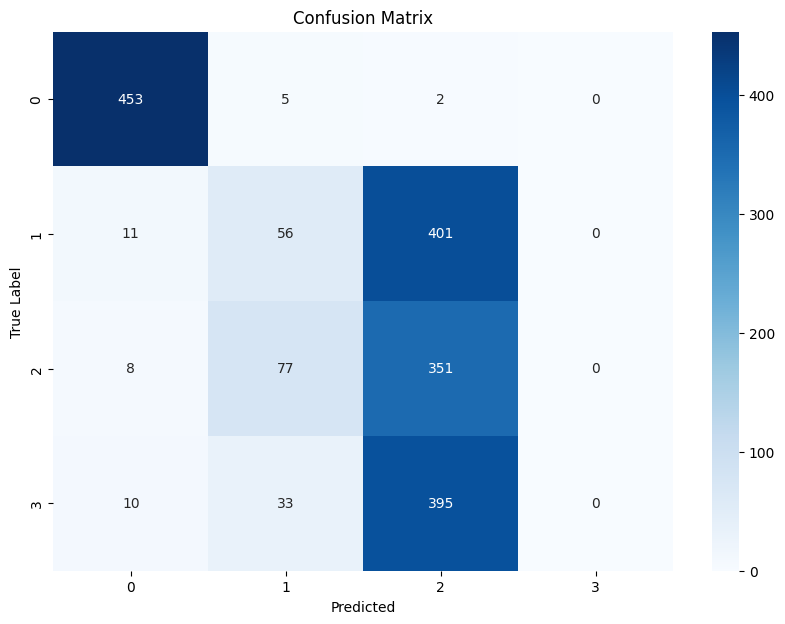

In [ ]:
!pip install matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix



# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Heatmap Visualization of the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Model Evaluation
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test_np, verbose=False)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100}%")

# Predictions
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_test_np, y_pred_classes, target_names=[f"Class {i}" for i in range(len(df['label'].unique()))], zero_division=0, output_dict=True)
print(classification_report(y_test_np, y_pred_classes, target_names=[f"Class {i}" for i in range(len(df['label'].unique()))], zero_division=0))

# Display overall averages
print("\nOverall Averages:")
print(f"Precision (macro avg): {report['macro avg']['precision']:.2f}")
print(f"Recall (macro avg): {report['macro avg']['recall']:.2f}")
print(f"F1-Score (macro avg): {report['macro avg']['f1-score']:.2f}")


Test Loss: 0.8995376229286194
Test Accuracy: 47.72475063800812%
57/57 [==============================] - 9s 153ms/step
Confusion Matrix:
[[453   5   2   0]
 [ 11  56 401   0]
 [  8  77 351   0]
 [ 10  33 395   0]]
              precision    recall  f1-score   support

     Class 0       0.94      0.98      0.96       460
     Class 1       0.33      0.12      0.18       468
     Class 2       0.31      0.81      0.44       436
     Class 3       0.00      0.00      0.00       438

    accuracy                           0.48      1802
   macro avg       0.39      0.48      0.39      1802
weighted avg       0.40      0.48      0.40      1802


Overall Averages:
Precision (macro avg): 0.39
Recall (macro avg): 0.48
F1-Score (macro avg): 0.39


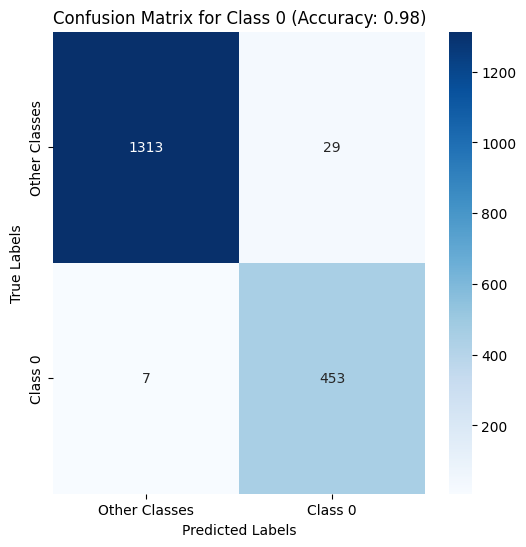

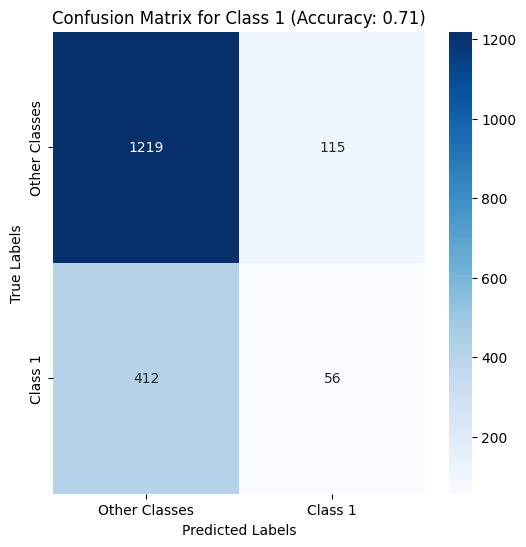

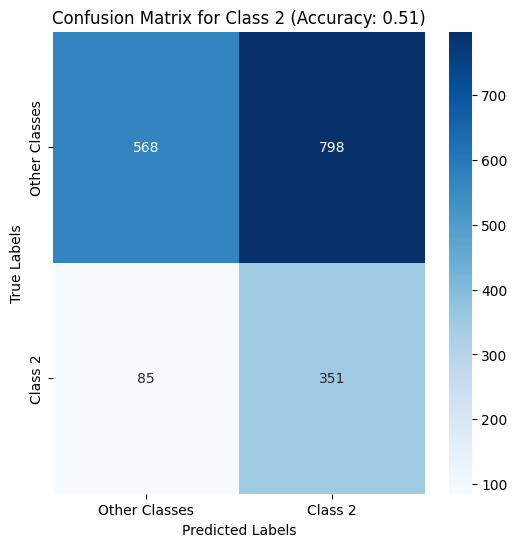

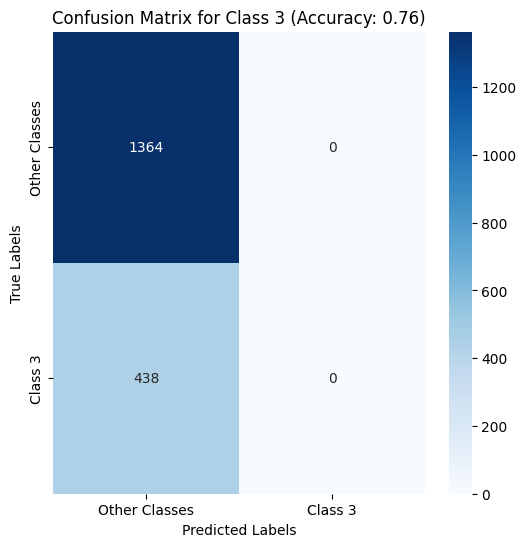

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 4 classes labeled as 0, 1, 2, 3
num_classes = 4

for i in range(num_classes):
    # Convert to binary classification - Class 'i' vs all other classes
    y_test_binary = (y_test_np == i).astype(int)
    y_pred_binary = (y_pred_classes == i).astype(int)

    # Generate confusion matrix for this binary classification
    cm = confusion_matrix(y_test_binary, y_pred_binary)

    # Calculate accuracy for this class
    # Accuracy = (True Positives + True Negatives) / Total
    class_accuracy = (cm[0][0] + cm[1][1]) / cm.sum()

    # Plotting the confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Other Classes', f'Class {i}'],
                yticklabels=['Other Classes', f'Class {i}'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for Class {i} (Accuracy: {class_accuracy:.2f})')
    plt.show()


# **Roc-Auc**

57/57 [==============================] - 10s 172ms/step


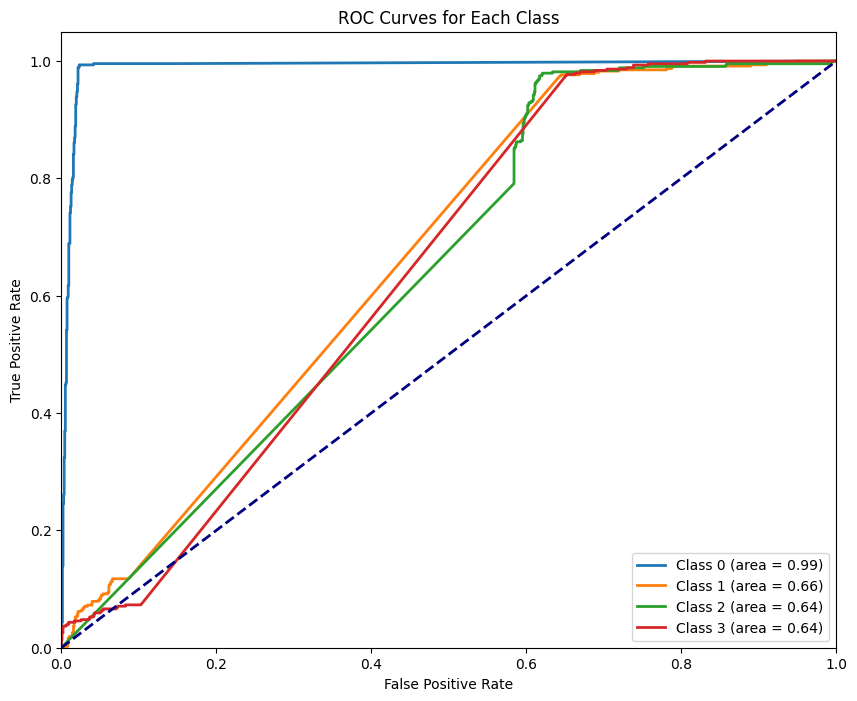

In [ ]:
!pip install scikit-learn matplotlib
import numpy as np
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Number of classes
num_classes = len(np.unique(y_test_np))

# Convert labels to one-hot encoding
y_test_one_hot = to_categorical(y_test_np, num_classes)
y_pred_prob = model.predict(X_test_padded)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, thresholds = roc_curve(y_test_one_hot[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()
